### Load dataset and extract SentenceTransformers embeddings and prompt categories

In [1]:
import pandas as pd
from collections import Counter

INPUT_FILE = "data/processed/malignant.csv"
df = pd.read_csv(INPUT_FILE)

embeddings = []
for embedding in df['embedding']:
    temp = [float(x.strip(' []')) for x in embedding.split(',')]
    embeddings.append(temp)

categories = []
for category in df['category']:
    categories.append(category)

print("Vector size:\t\t\t", len(embeddings[0]))
print("Number of embeddings:\t\t", len(embeddings))
print("Number of category entries:\t", len(categories))
category_count = Counter(categories)

for item, count in category_count.items():
    print(f'\t{item}: {count}')

Vector size:			 384
Number of embeddings:		 1496
Number of category entries:	 1496
	conversation: 1402
	jailbreak: 70
	act_as: 24


### Create dictionary mapping each embedding to a unique category value

In [2]:
data_dict = {}

for i, embedding in enumerate(embeddings):
    category = categories[i]

    if category not in data_dict:
        data_dict[category] = []
    
    data_dict[category].append(embedding)


data_dict = {k: v for k, v in data_dict.items() if len(v) > 1}

Demonstrate dictionary structure



In [3]:
for key, value in list(data_dict.items())[:3]:
    print(f"{key}: {value[:2]}")

conversation: [[0.6487895846366882, -0.17706210911273956, 0.26846253871917725, 0.18905383348464966, -0.33726221323013306, -0.3302522301673889, 0.19196242094039917, 0.31563907861709595, -0.29508668184280396, 0.09558296203613281, 0.08327564597129822, -0.30192962288856506, -0.1834355741739273, -0.030582385137677193, 0.08354801684617996, 0.025754356756806374, -0.09357529878616333, -0.4416128396987915, -0.6328431963920593, -0.12889698147773743, -0.6578927636146545, -0.11932878941297531, -0.3738086521625519, -0.0864822268486023, 0.4625754952430725, 0.1258043497800827, 0.009837444871664047, 0.32809606194496155, -0.3845890462398529, -0.350810706615448, -0.0006223793025128543, -0.13784588873386383, 0.32487356662750244, 0.07625002413988113, 0.005976521410048008, 0.5497534871101379, 0.039890170097351074, -0.23408359289169312, -0.0031182989478111267, 0.02026244066655636, 0.08132883906364441, -0.26453620195388794, 0.1429012417793274, 0.1672365665435791, 0.24232707917690277, -0.17889976501464844, -0

In [4]:
print(len(data_dict['conversation']))
print(len(data_dict['jailbreak']))
print(len(data_dict['act_as']))

1402
70
24


### Load data for triplet loss

In [5]:
from triplet_dataset import TripletDataset
from torch.utils.data import DataLoader

siamese_dataset = TripletDataset(data_dict, False)

# Load the training dataset
num_workers = 4
batch_size = 1800
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, num_workers=num_workers, batch_size=batch_size
)

### Initialize siamese network

In [6]:
from torch import optim
import torch.nn as nn

from siamese_network import SiameseNetwork

embedding_dim = 128

siamese_net = SiameseNetwork(embedding_dim).cuda()
margin = 0.3
criterion = nn.TripletMarginLoss(margin=margin)

learning_rate = 0.0001
optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)

n_epochs = 200

print(siamese_net)
print(f"Number of epochs: {n_epochs}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")
print(f"Loss function: TripletMarginLoss")
print(f"Margin: {margin}")
print(f"Batch size: {batch_size}")
print(f"Number of workers: {num_workers}")
print(f"Dataset: {INPUT_FILE}")
print(f"Number of classes: {3}")
print(f"Number of samples: {len(siamese_dataset)}")

SiameseNetwork(
  (embedding): Sequential(
    (0): Linear(in_features=384, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)
Number of epochs: 200
Embedding dimension: 128
Optimizer: Adam
Learning rate: 0.0001
Loss function: TripletMarginLoss
Margin: 0.3
Batch size: 1800
Number of workers: 4
Dataset: data/processed/malignant.csv
Number of classes: 3
Number of samples: 1496


In [7]:
def train(n_epochs, model, optimizer, criterion):
    global train_dataloader
    best_loss = float("inf")
    best_state = None
    iteration_number = 0
    counter = []
    loss_history = []

    for epoch in range(n_epochs):
        # Iterate over batches
        for i, (anchor, positive, negative) in enumerate(train_dataloader, 0):
            # Send the images to CUDA
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the anchor, positive, and negative images into the network
            output_anchor, output_positive, output_negative = model(anchor, positive, negative)

            # Compute the triplet loss
            loss_triplet = criterion(output_anchor, output_positive, output_negative)

            # If the validation loss is at a minimum
            if loss_triplet < best_loss:
                best_loss = loss_triplet
                best_state = model.state_dict()

            # Backpropagation
            loss_triplet.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss
            if i % 10 == 0:
                print(f"Epoch number {epoch}\n Current loss {loss_triplet.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_triplet.item())

    print("Training finished")
    # print(counter)
    # print(loss_history)
    return counter, loss_history, best_state, best_loss

In [8]:
import matplotlib.pyplot as plt

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

### Train siamese network and log metrics

In [9]:
%%time
import time
from datetime import datetime

start_time = time.time()
# Training
counter, loss_history, best_state, best_loss = train(n_epochs, siamese_net, optimizer, criterion)
end_time = time.time()
execution_time = end_time - start_time

minutes, seconds = divmod(execution_time, 60)

Epoch number 0
 Current loss 0.2872006893157959

Epoch number 1
 Current loss 0.27830150723457336

Epoch number 2
 Current loss 0.27435222268104553

Epoch number 3
 Current loss 0.265026718378067

Epoch number 4
 Current loss 0.25416672229766846

Epoch number 5
 Current loss 0.24597519636154175

Epoch number 6
 Current loss 0.23266668617725372

Epoch number 7
 Current loss 0.22089727222919464

Epoch number 8
 Current loss 0.20917940139770508

Epoch number 9
 Current loss 0.1945122331380844

Epoch number 10
 Current loss 0.18029959499835968

Epoch number 11
 Current loss 0.16222037374973297

Epoch number 12
 Current loss 0.15020382404327393

Epoch number 13
 Current loss 0.1281227320432663

Epoch number 14
 Current loss 0.11728454381227493

Epoch number 15
 Current loss 0.0977301150560379

Epoch number 16
 Current loss 0.08489961177110672

Epoch number 17
 Current loss 0.07348794490098953

Epoch number 18
 Current loss 0.06609378010034561

Epoch number 19
 Current loss 0.054524499922990

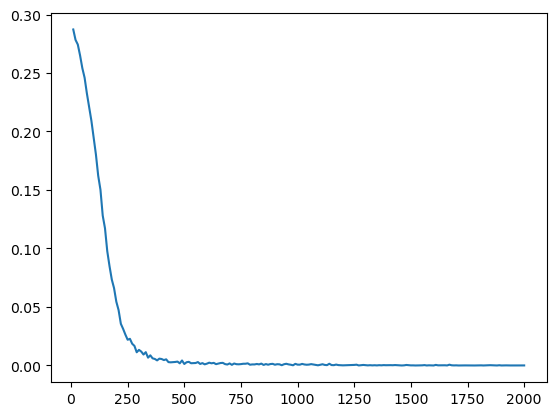

In [10]:
show_plot(counter, loss_history)

In [11]:
print(best_loss)

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)


### Save model

In [12]:
from datetime import datetime
import os
import torch

now = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

# create folder
model_dir = f"trained/{now}"
os.makedirs(model_dir, exist_ok=True)
# Save the trained model
torch.save(siamese_net.state_dict(), os.path.join(model_dir, "state.pth"))

# Save the best state
torch.save(best_state, os.path.join(model_dir, f"best_state-{best_loss}.pth"))

torch.save(siamese_net, os.path.join(model_dir, "model.pth"))
with open(os.path.join(model_dir, "Architecture.txt"), "w") as f:
    f.write(str(siamese_net))
    f.write(f"\nExecution time: {int(minutes)} minutes and {seconds:.2f} seconds\n")
    f.write(f"Number of epochs: {n_epochs}\n")
    f.write(f"Embedding dimension: {embedding_dim}\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Learning rate: {learning_rate}\n")
    f.write(f"Loss function: TripletMarginLoss\n")
    f.write(f"Margin: {margin}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Number of workers: {num_workers}\n")
    f.write(f"Dataset: {INPUT_FILE}\n")
    f.write(f"Number of classes: {len(data_dict)}\n")
    f.write(f"Number of samples: {len(siamese_dataset)}\n")

In [13]:
import torch

malicious_model = torch.load(os.path.join(model_dir, "model.pth"))

### Evaluate best threshold and AUC

In [14]:
import importlib
import roc_curve
importlib.reload(roc_curve)

fpr, tpr, roc_auc, best_threshold = roc_curve.main(malicious_model, plot=True, folder=model_dir)
print(f"Best threshold: {best_threshold}")
print(f"AUC: {roc_auc}")

Vector size:			 384
Number of embeddings:		 1496
Number of category entries:	 1496
Best threshold: 1.1311498977575187
AUC: 0.9999946000000001
